In [325]:
from pendulum_forces import MagneticPendulumInvSpherical, MagneticPendulumXY
import numpy as np
import sympy as sp
from scipy.constants import g as g_value
from scipy.integrate import solve_ivp

In [326]:
P = MagneticPendulumInvSpherical(4)
# P = MagneticPendulumXY(4)

const1_subs = {
    'm': 1,
    'g': g_value,
    'L': g_value,
    'R': 2,
    'h': 0.5,
    'b': 0.1,   
}
magnet_strength = 10

magnet_polarity_vals = dict((p.name, magnet_strength) for p in P.polarity_list)
constant_subs = const1_subs | magnet_polarity_vals

bob = P.create_bob(constant_subs=constant_subs)

In [327]:
t_max = 500
dt = 0.001

## specifically for spherical
to_x = lambda r,θ,ϕ: r*np.sin(θ)*np.cos(ϕ)
to_y = lambda r,θ,ϕ: r*np.sin(θ)*np.sin(ϕ)
to_z = lambda r,θ,ϕ: -r*np.cos(θ)
to_cartesian = lambda r,θ,ϕ: [to_x(r,θ,ϕ), to_y(r,θ,ϕ), to_z(r,θ,ϕ)]


starting_pos_1 = np.array([
    constant_subs['L'],
    0.19166740685923828*3/4 * 5,
    np.pi/10
])
####

starting_pos_array = np.array([
    starting_pos_1
])

final_pos_array = np.zeros(starting_pos_array.shape)


In [328]:
starting_pos_array[0]

array([9.80665   , 0.71875278, 0.31415927])

In [329]:
starting_pos_1 = np.array([
    constant_subs['L'],
    0.19166740685923828*3/4 * 5,
    np.pi/10
])




In [330]:
resolution=30
r_const = constant_subs['L']
phi = np.linspace(0, 2*np.pi, 2*resolution, endpoint=False)
theta = np.linspace(0, np.pi, resolution, endpoint=False)

theta_mesh, phi_mesh = np.meshgrid(theta, phi)



In [331]:
# def get_final_position(θ_start, ϕ_start):
#     starting_conditions = [r_const, θ_start, ϕ_start, 0,0,0]
#     final_pos_spherical = P.get_path(starting_conditions, t_max=t_max, dt=0.01,
#                       bob=bob, **constant_subs)[:,-1]
#     return final_pos_spherical[1], final_pos_spherical[2]

In [332]:
# θ_start, ϕ_start = theta_mesh[0][0], phi_mesh[0][0]


# starting_pos = np.array([r_const, θ_start, ϕ_start, 0,0,0])
# # P.get_path(, t_max=t_max, dt=0.01,
# #                       bob=bob, **constant_subs)

# ddt = P._get_ddt(bob=bob)

In [333]:
starting_θ_ϕ_pairs = np.array(np.meshgrid(theta, phi)).T.reshape(-1,2)

ddt = P._get_ddt(bob=bob)

In [334]:
[e.E for e in P.energy_dict.values()][0]

-g*m*r(t)*cos(θ(t))

In [335]:
def stop_event(t, y):
    return min(time.time() - start_time - 10, len(y) - 1000)

In [336]:
from tqdm.notebook import tqdm

In [ ]:
t_max = 500
dt = 0.001

In [338]:
final_positions_array = np.empty_like(starting_θ_ϕ_pairs)
np_eps = np.finfo(np.float64).eps

t_vals = np.arange(0, t_max, dt)

for i, (θ_start, ϕ_start) in enumerate(tqdm(starting_θ_ϕ_pairs)):
    
    if abs(θ_start % np.pi) <= np_eps:
        if θ_start == 0:
            θ_start = np_eps
        else:
            θ_start -= 10*np_eps

    starting_pos = np.array([r_const, θ_start, ϕ_start, 0,0,0])
    final_positions_array[i] = solve_ivp(ddt, (0, t_max), starting_pos, t_eval=t_vals, method='RK45').y[1:3, -1]    

  0%|          | 0/1800 [00:00<?, ?it/s]

In [340]:
final_positions_array

array([[-1.88472673e-01,  0.00000000e+00],
       [ 1.71730814e-19,  1.04719755e-01],
       [ 4.28788819e-17,  2.09439510e-01],
       ...,
       [ 1.88461511e-01,  3.14157915e+00],
       [ 1.88460233e-01,  1.72787575e+01],
       [ 1.88461140e-01,  1.25663750e+01]])

In [505]:
def col_map(x):
    if x == 0:
        return "lime"
    if x == 1:
        return 'red'
    if x == 2:
        return 'blue'
    if x == 3:
        return 'yellow'
    else:
        return 'black'

In [507]:
magnet_positions = []
for magnet_pos in P.magnet_positions_C:
    magnet_pos = magnet_pos.subs(constant_subs)
    magnet_positions.append([magnet_pos.dot(P.coordsystem.C.i), magnet_pos.dot(P.coordsystem.C.j), magnet_pos.dot(P.coordsystem.C.k)])
magnet_positions

equilibria_regions = np.array(magnet_positions + [[0,0,magnet_positions[0][2]]], dtype=np.float64)
equilibria_regions

array([[  2.     ,   0.     , -10.30665],
       [  0.     ,   2.     , -10.30665],
       [ -2.     ,   0.     , -10.30665],
       [  0.     ,  -2.     , -10.30665],
       [  0.     ,   0.     , -10.30665]])

(-9.80665, 9.80665)

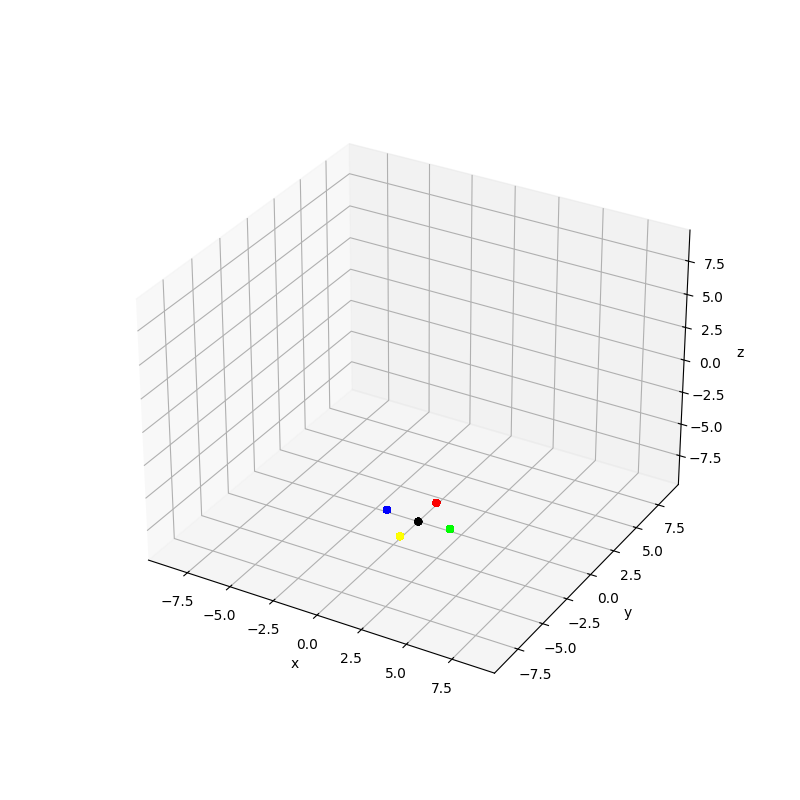

In [516]:
# wld like to change it but this does do colour for now...
final_positions_array_cart = np.array(to_cartesian(r_const, final_positions_array[:,0], final_positions_array[:,1]))
clusters = kmeans2(final_positions_array_cart.T, k=equilibria_regions)
groups = clusters[1]
## end

xs, ys, zs = to_cartesian(r_const, final_positions_array[:, 0], final_positions_array[:, 1])

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
clist = [col_map(x) for x in groups]
ax.scatter3D(xs, ys, zs, c=clist)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

L = r_const
ax.set_xlim(-L,L)
ax.set_ylim(-L,L)
ax.set_zlim(-L,L)

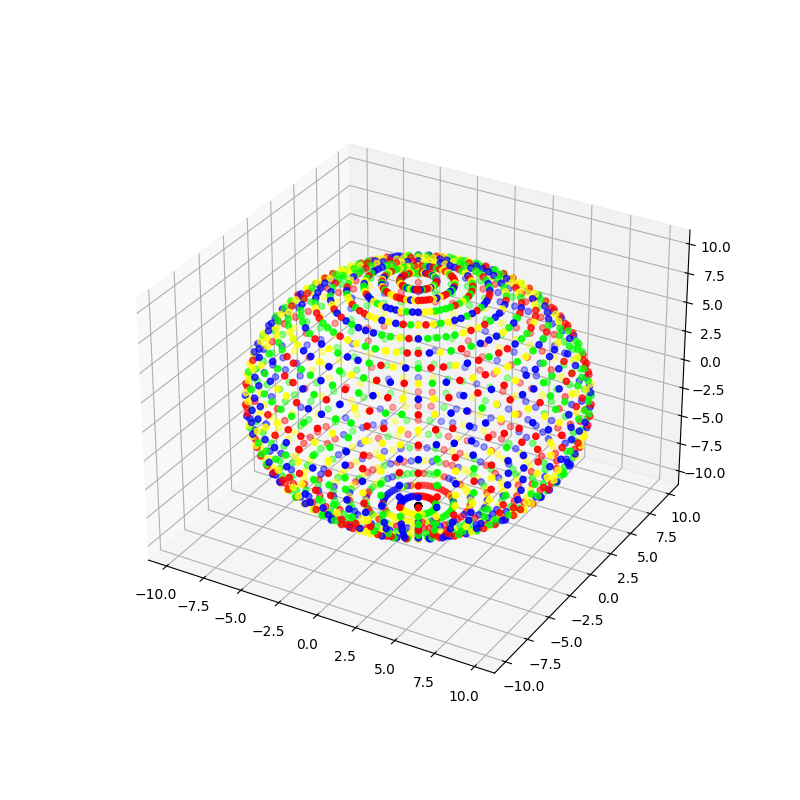

In [517]:
sphere_xs, sphere_ys, sphere_zs = to_cartesian(r_const, starting_θ_φ_pairs[:,0], starting_θ_φ_pairs[:,1])

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
ax.scatter(sphere_xs, sphere_ys, sphere_zs, c=clist)
plt.show()